#conda install -c plotly plotly

In [1]:
# This code calculates the KGE and other stats for comparing EFAS output with observed flow timeseries
import pandas as pd
import numpy as np
from numpy.random import rand
import plotly.express as px
import matplotlib
from calendar import monthrange
from datetime import datetime
# Using graph_objects
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plot
from plotly.subplots import make_subplots
pd.plotting.register_matplotlib_converters()
import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
EfasSel = pd.read_excel('Dis24_Chosen_ky.xlsx', index_col=0)
#station = stations.sample(n=1) # We can randomly choose a station
#EfasSel.set_index('Date', inplace=True)

ObsSel = pd.read_excel('Agi_Chosen_ky.xlsx', index_col=0)
#station = stations.sample(n=1) # We can randomly choose a station
#ObsSel.set_index('Date', inplace=True)

EfasInfo = pd.read_excel('chosen_ky.xlsx', index_col=0)

## Calculate Signatures
Stats = pd.DataFrame()
StatsCalc = pd.DataFrame()

In [3]:
# FDC Signatures
# Sort observed and simulated flows

ObsSelSort = ObsSel.apply(lambda x: x.sort_values(ascending=False).values)
EfasSelSort = EfasSel.apply(lambda x: x.sort_values(ascending=False).values)
leng=len(EfasSelSort)
EfasSelSort['Ind'] = range(1, leng+1)
EfasSelSort['Ind'] = EfasSelSort['Ind'].div(leng)
EfasSelSort.set_index('Ind', inplace=True)
ObsSelSort['Ind'] = range(1, leng+1)
ObsSelSort['Ind'] = ObsSelSort['Ind'].div(leng)
ObsSelSort.set_index('Ind', inplace=True)

ObsSelSortNorm = ObsSelSort.copy()
EfasSelSortNorm = EfasSelSort.copy()

In [4]:
# Normalize by watershed area
for pg in ObsSelSort.columns:
    areas = float(EfasInfo.area[(EfasInfo['stname'] == pg)])
    ObsSelSortNorm[pg] = 1000*(ObsSelSort[pg] / (areas*1000000)) #  convert km2 to m2 than to mm
    EfasSelSortNorm[pg] = 1000*(EfasSelSort[pg] / (areas*1000000))

IndexError: index 15 is out of bounds for axis 0 with size 15

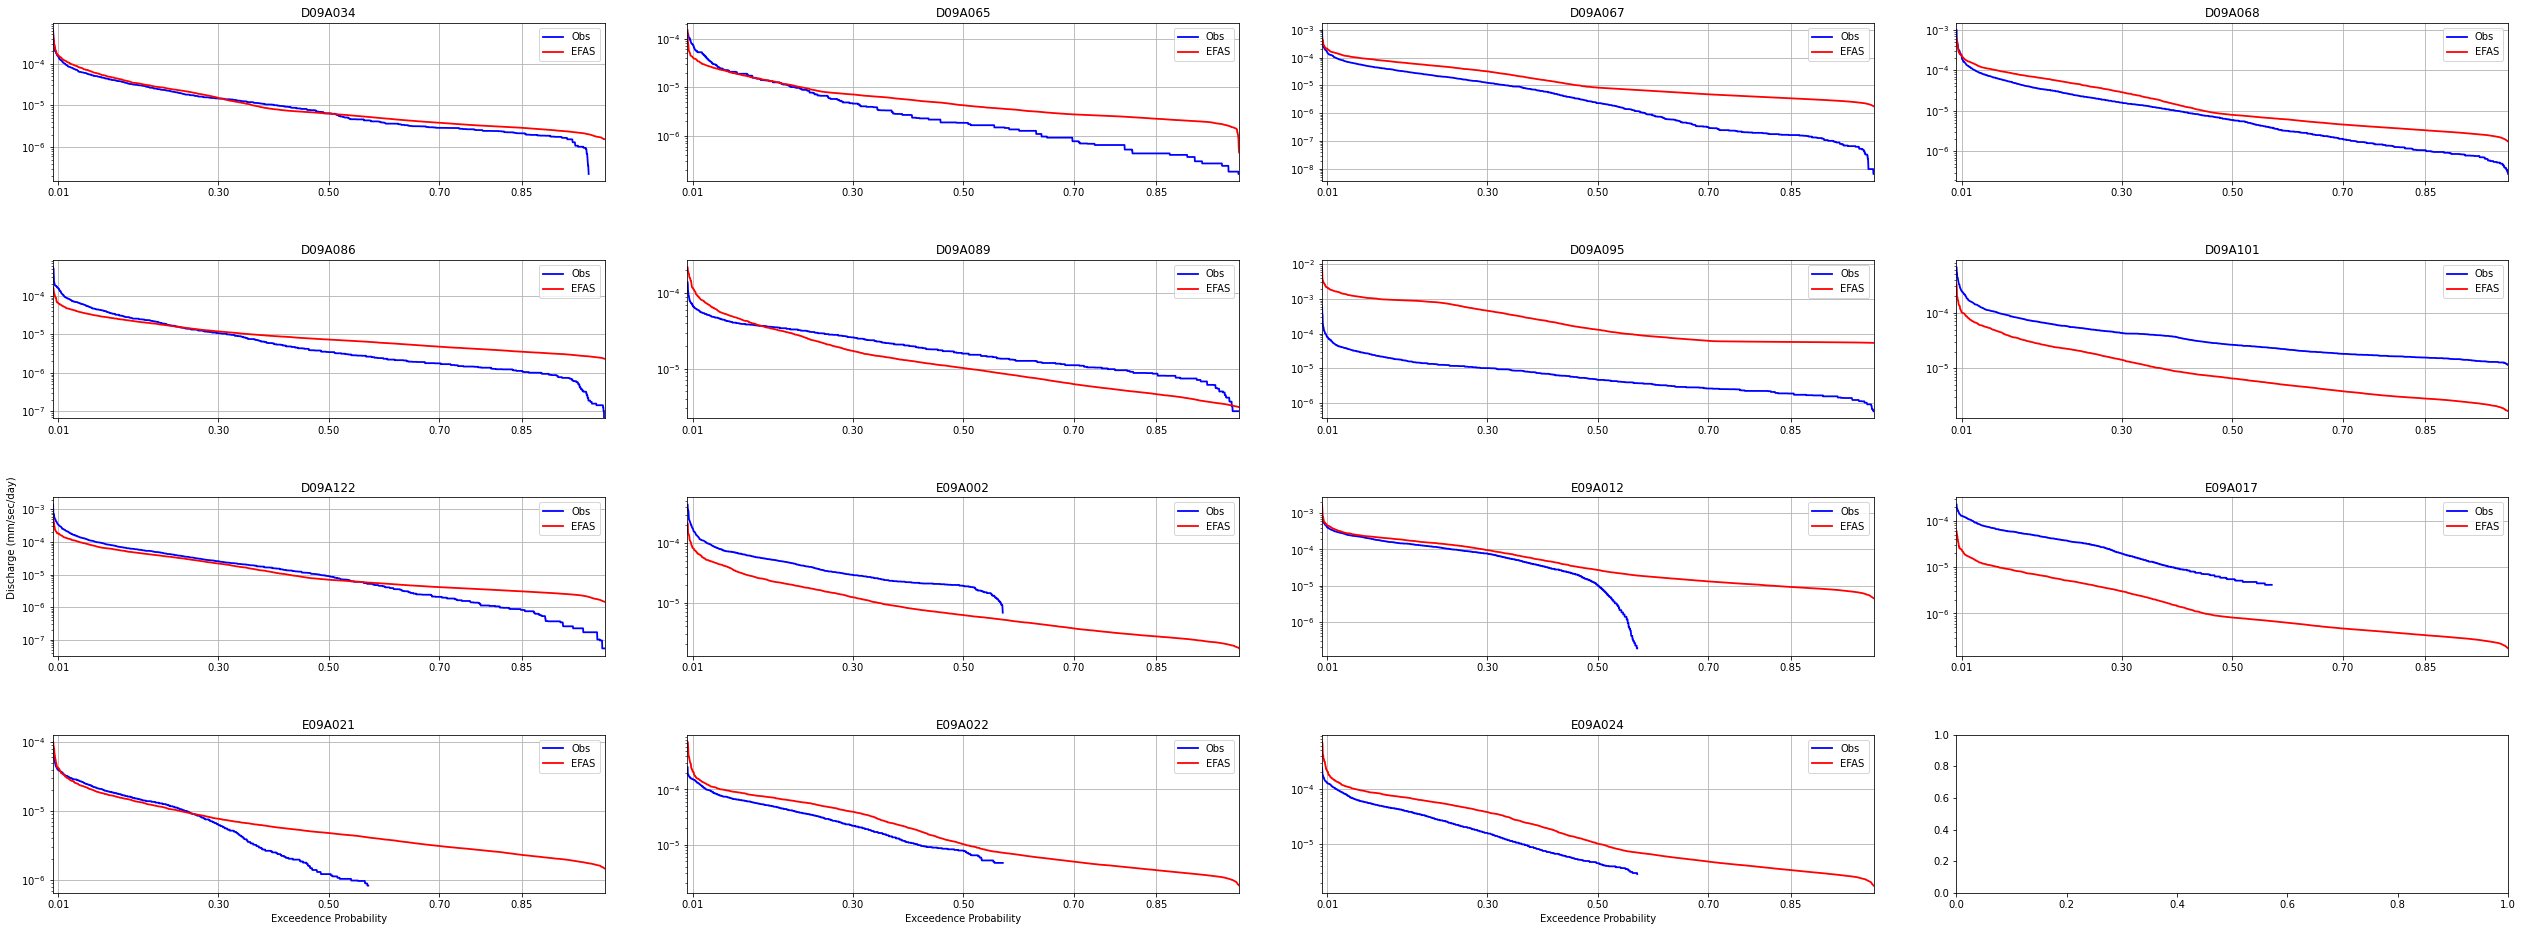

In [5]:
# Plot FDCs
fig, axs = plot.subplots(4,4, figsize=(44, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.15)
axs = axs.ravel()
for i in range(16):
    axs[i].plot(ObsSelSort.columns[i], data=ObsSelSortNorm,  linestyle='-', color='blue', linewidth=1.8, label='Obs')
    axs[i].plot(ObsSelSort.columns[i], data=EfasSelSortNorm,  linestyle='-', color='red', linewidth=1.8, label='EFAS')
    axs[i].set_yscale('log')
    axs[i].set_title(str(ObsSelSort.columns[i]))
    axs[i].set_xticks([0.01, 0.3, 0.5, 0.7, 0.85])
    axs[i].grid()
    axs[i].set_xlim(left=0, right=1)
    axs[i].legend()
    if i == 8:
        axs[i].set_ylabel('                         Discharge (mm/sec/day)', fontsize=10)
    if i > 11:
        axs[i].set_xlabel('Exceedence Probability', fontsize=10)

fig.savefig('FDC_Obs_Sim_Antalya.png')
fig.show()


In [6]:
# Define FDC thresholds
H5 = round(0.01 * len(ObsSelSortNorm)) + 1
H30 = round(0.30 * len(ObsSelSortNorm)) + 1
H50 = round(0.50 * len(ObsSelSortNorm)) + 1
H70 = round(0.70 * len(ObsSelSortNorm)) + 1
H85 = round(0.85 * len(ObsSelSortNorm)) + 1

In [7]:
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSelSortNorm[pg], ObsSelSortNorm[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    leng = len(TSSel)
    TSSel['Ind'] = range(0, leng )
    TSSel.set_index('Ind', inplace=True)
    # For observed values
    TSSel["H5Obs"] = np.log10(TSSel['Obs'][H5])
    TSSel["H50Obs"] = np.log10(TSSel['Obs'][H50])
    TSSel["H85Obs"] = np.log10(TSSel['Obs'][H85])
    TSSel["HSLObs"] = np.log10(TSSel['Obs'][H30]) - np.log10(TSSel['Obs'][H70])
    # For sim values
    TSSel["H5Sim"] = np.log10(TSSel['Sim'][H5])
    TSSel["H50Sim"] = np.log10(TSSel['Sim'][H50])
    TSSel["H85Sim"] = np.log10(TSSel['Sim'][H85])
    TSSel["HSLSim"] = np.log10(TSSel['Sim'][H30]) - np.log10(TSSel['Sim'][H70])

    StatsCalc = TSSel.iloc[0]
    StatsCalc["Station"] = pg

    Stats = Stats.append(StatsCalc)

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp/ipykernel_7252/4034828815.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



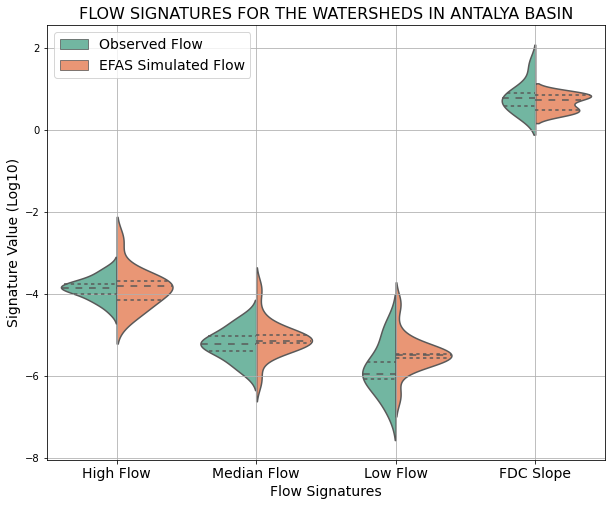

In [8]:
# Export Stats
Stats.to_excel('Stats_Antalya.xlsx')
StatsMeltedObs = Stats.melt(id_vars='Station', value_vars=["H5Obs", "H50Obs", "H85Obs", "HSLObs" ])
StatsMeltedSim = Stats.melt(id_vars='Station', value_vars=["H5Sim", "H50Sim", "H85Sim", "HSLSim" ])
StatsMeltedObs["Type"] = "Observed Flow"
StatsMeltedSim["Type"] = "EFAS Simulated Flow"
StatsMeltedObs['variable'] = StatsMeltedObs['variable'].map(lambda x: x.rstrip('Obs'))
StatsMeltedSim['variable'] = StatsMeltedSim['variable'].map(lambda x: x.rstrip('Sim'))

StatsMelted = pd.concat([StatsMeltedObs, StatsMeltedSim], ignore_index=True)
fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", hue="Type", data=StatsMelted, palette="Set2", split=True,
                    scale="count", inner="quartile")
axv.grid()
axv.legend(loc=2,prop={'size':14})
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['High Flow','Median Flow','Low Flow','FDC Slope']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('FLOW SIGNATURES FOR THE WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Signature Value (Log10)', fontsize=14)
axv.set_xlabel('Flow Signatures', fontsize=14)
fig.show()
fig.savefig('FDC_Signatures_Antalya.png')

In [9]:
print(StatsMelted)

     Station variable     value                 Type
0    D09A034       H5 -3.855226        Observed Flow
1    D09A065       H5 -4.140955        Observed Flow
2    D09A067       H5 -3.847252        Observed Flow
3    D09A068       H5 -3.730873        Observed Flow
4    D09A086       H5 -3.822666        Observed Flow
..       ...      ...       ...                  ...
115  E09A012      HSL  0.861537  EFAS Simulated Flow
116  E09A017      HSL  0.801147  EFAS Simulated Flow
117  E09A021      HSL  0.395444  EFAS Simulated Flow
118  E09A022      HSL  0.904659  EFAS Simulated Flow
119  E09A024      HSL  0.897270  EFAS Simulated Flow

[120 rows x 4 columns]


C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_7252/161077989.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



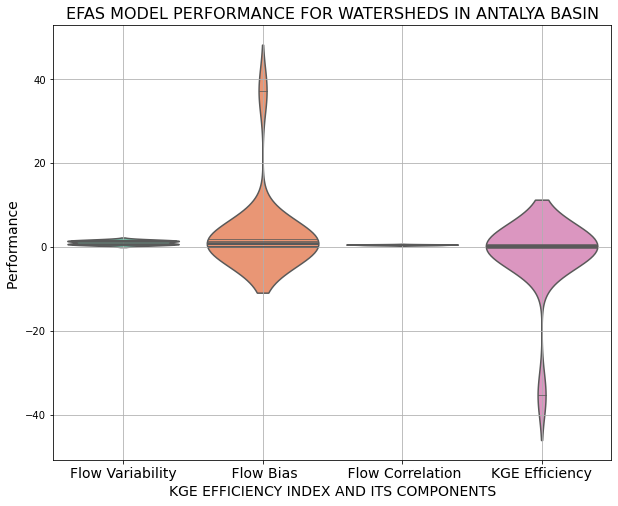

In [10]:
##KGE and Components
KGE = pd.DataFrame()
KGECalc = pd.DataFrame()
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSel[pg], ObsSel[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    # Calculate KGE Components
    TSSel["MeanObs"] = TSSel["Obs"].mean()
    TSSel["MeanSim"] = TSSel["Sim"].mean()

    TSSel["StdObs"] = TSSel["Obs"].std() / TSSel["MeanObs"]
    TSSel["StdSim"] = TSSel["Sim"].std() / TSSel["MeanSim"]

    TSSel["Alpha"] = TSSel["StdSim"] / TSSel["StdObs"]
    TSSel["Beta"] = TSSel["MeanSim"] / TSSel["MeanObs"]

    TSSel["Corr"] = TSSel["Sim"].corr(TSSel["Obs"])
    TSSel["KGE"] = 1 - ((TSSel["Corr"] - 1)**2 + (TSSel["Alpha"] - 1)**2 + (TSSel["Beta"] - 1)**2)**0.5
    KGECalc = TSSel.iloc[0]
    KGECalc["Station"] = pg

    KGE = KGE.append(KGECalc)

# Export KGE
KGE.to_excel('Stats_KGE_Antalya.xlsx')

# Plot KGE and Components
KGEMelted = KGE.melt(id_vars='Station', value_vars=["Alpha", "Beta", "Corr", "KGE"])

fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", data=KGEMelted, palette="Set2", split=True,
                    scale="count", inner="stick")
axv.grid()
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['Flow Variability',' Flow Bias',' Flow Correlation','KGE Efficiency']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('EFAS MODEL PERFORMANCE FOR WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Performance ', fontsize=14)
axv.set_xlabel('KGE EFFICIENCY INDEX AND ITS COMPONENTS', fontsize=14)
fig.show()
fig.savefig('KGE_Components_Antalya.png')

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Fill NaN values with Mean Value of column

In [11]:
# Total Number of NaN values in every columns
ObsSel.isnull().sum(axis = 0)

D09A034      74
D09A065       0
D09A067       0
D09A068       0
D09A086       0
D09A089       0
D09A095       0
D09A101       0
D09A122       0
E09A002    1095
E09A012    1095
E09A017    1095
E09A021    1095
E09A022    1095
E09A024    1095
dtype: int64

In [12]:
ObsSel.isnull().sum().sort_values(ascending = False)

E09A002    1095
E09A012    1095
E09A017    1095
E09A021    1095
E09A022    1095
E09A024    1095
D09A034      74
D09A065       0
D09A067       0
D09A068       0
D09A086       0
D09A089       0
D09A095       0
D09A101       0
D09A122       0
dtype: int64

In [13]:
ObsSel.E09A002.mean()

85.37727583846673

In [14]:
ObsSel.E09A002.median()

59.6

List = ObsSel.E09A002.dropna()
lis = pd.DataFrame(List)
lis["Efas_E09A002"]= pd.DataFrame(EfasSel.E09A002)
lis

In [15]:
# Fill NaN values with mean of data
ObsSel.E09A002 = ObsSel.E09A002.fillna(ObsSel.E09A002.median())

ObsSel.E09A012 = ObsSel.E09A012.fillna(ObsSel.E09A012.median())
ObsSel.E09A017 = ObsSel.E09A017.fillna(ObsSel.E09A017.median())
ObsSel.E09A021 = ObsSel.E09A021.fillna(ObsSel.E09A021.median())
ObsSel.E09A022 = ObsSel.E09A022.fillna(ObsSel.E09A022.median())
ObsSel.E09A024 = ObsSel.E09A024.fillna(ObsSel.E09A024.median())
ObsSel.D09A034 = ObsSel.D09A034.fillna(ObsSel.D09A034.median())

In [16]:
ObsSel.isnull().sum().sort_values(ascending = False)

D09A034    0
D09A065    0
D09A067    0
D09A068    0
D09A086    0
D09A089    0
D09A095    0
D09A101    0
D09A122    0
E09A002    0
E09A012    0
E09A017    0
E09A021    0
E09A022    0
E09A024    0
dtype: int64

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Identifying Outliers with Interquartile Range (IQR)

In [17]:
# interquartile range for each of the variables in the dataset.
Q1 = ObsSel.quantile(0.25)
Q3 = ObsSel.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

D09A034     3.4980
D09A065     0.6210
D09A067     5.1400
D09A068     6.3650
D09A086     4.1765
D09A089     5.7900
D09A095     1.4950
D09A101    74.7000
D09A122     4.6530
E09A002    12.6000
E09A012    18.7000
E09A017    11.1250
E09A021     4.1300
E09A022     3.8250
E09A024     5.0000
dtype: float64


In [18]:
# The code below generates an output with the 'True' and 'False' values. 
# Points where the values are 'True' represent the presence of the outlier.
print(ObsSel < (Q1 - 1.5 * IQR)) |(ObsSel > (Q3 + 1.5 * IQR))

            D09A034  D09A065  D09A067  D09A068  D09A086  D09A089  D09A095  \
datetime                                                                    
2008-10-01    False    False    False    False    False    False    False   
2008-10-02    False    False    False    False    False    False    False   
2008-10-03    False    False    False    False    False    False    False   
2008-10-04    False    False    False    False    False    False    False   
2008-10-05    False    False    False    False    False    False    False   
...             ...      ...      ...      ...      ...      ...      ...   
2015-09-26    False    False    False    False    False    False    False   
2015-09-27    False    False    False    False    False    False    False   
2015-09-28    False    False    False    False    False    False    False   
2015-09-29    False    False    False    False    False    False    False   
2015-09-30    False    False    False    False    False    False    False   

TypeError: Cannot perform 'ror_' with a dtyped [bool] array and scalar of type [NoneType]

In [19]:
# Skewness
# The first line of code below prints the skewness value for the 'D09A034' station,
# while the second line prints the summary statistics.
print(ObsSel['D09A034'].skew())
ObsSel['D09A034'].describe()

7.229284418638928


count    2556.000000
mean        4.093523
std         7.578700
min         0.054000
25%         0.682000
50%         1.670000
75%         4.180000
max       151.000000
Name: D09A034, dtype: float64

## Visualization

<AxesSubplot:>

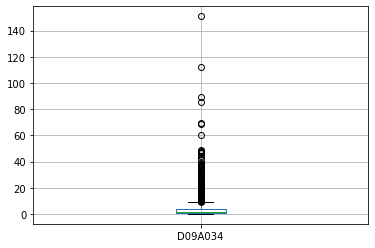

In [20]:
# Box Plot
ObsSel.boxplot(column='D09A034')

<AxesSubplot:>

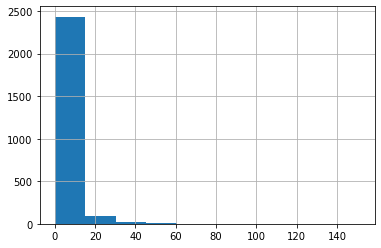

In [21]:
# Histogram
ObsSel.D09A034.hist()

# Outlier Treatment

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## Quantile-based Flooring and Capping

In this technique, we will do the flooring (e.g., the 10th percentile) for the lower values and capping (e.g., the 90th percentile) for the higher values. The lines of code below print the 10th and 90th percentiles of the station 'D09A034', respectively. These values will be used for quantile-based flooring and capping.

In [23]:
print(ObsSel['D09A034'].quantile(0.10))
print(ObsSel['D09A034'].quantile(0.90))

0.467
10.3


In [24]:
# To check getting values possible with iloc
print(ObsSel.iloc[:,0].quantile(0.10))
print(ObsSel.iloc[:,0].quantile(0.90))

0.467
10.3


In [25]:
# Remove Outliers, Find Skewness
ObsSel['D09A034'] = np.where(ObsSel['D09A034'] <0.467, 0.467,ObsSel['D09A034'])
ObsSel['D09A034'] = np.where(ObsSel['D09A034'] >10.3, 10.3,ObsSel['D09A034'])
print(ObsSel['D09A034'].skew())

1.248450390745067


In [26]:
# To check getting values possible with iloc

ObsSel.iloc[:,0] = np.where(ObsSel.iloc[:,0] <ObsSel.iloc[:,0].quantile(0.10), ObsSel.iloc[:,0].quantile(0.10),ObsSel.iloc[:,0])
ObsSel.iloc[:,0] = np.where(ObsSel.iloc[:,0] >ObsSel.iloc[:,0].quantile(0.90), ObsSel.iloc[:,0].quantile(0.90),ObsSel.iloc[:,0])
print(ObsSel.columns[0] , ObsSel.iloc[:,0].skew())

D09A034 1.248450390745067


In [27]:
# Loop for Agi
# quantile 0.10, 0.90
# quantile 0.25, 0.75
for i in range(len(ObsSel.columns)):
    ObsSel.iloc[:,i] = np.where(ObsSel.iloc[:,i] <ObsSel.iloc[:,i].quantile(0.25), ObsSel.iloc[:,i].quantile(0.25),ObsSel.iloc[:,i])
    ObsSel.iloc[:,i] = np.where(ObsSel.iloc[:,i] >ObsSel.iloc[:,i].quantile(0.75), ObsSel.iloc[:,i].quantile(0.75),ObsSel.iloc[:,i])    
    print( ObsSel.columns[i] , ObsSel.iloc[:,i].skew())

D09A034 0.3660313328179064
D09A065 0.5991689820661544
D09A067 0.5686427503003131
D09A068 0.45132469343978987
D09A086 0.5307445960848622
D09A089 0.31942434515018203
D09A095 0.3586954173981038
D09A101 0.2963269099558798
D09A122 0.4558336522821621
E09A002 0.09421854491043843
E09A012 -0.11398361758828099
E09A017 0.18166990502598215
E09A021 0.11140532426590906
E09A022 0.1680249638522736
E09A024 0.28910185501925906


In [28]:
# Loop for Efas
for i in range(len(EfasSel.columns)):
    EfasSel.iloc[:,i] = np.where(EfasSel.iloc[:,i] <EfasSel.iloc[:,i].quantile(0.25), EfasSel.iloc[:,i].quantile(0.25),EfasSel.iloc[:,i])
    EfasSel.iloc[:,i] = np.where(EfasSel.iloc[:,i] >EfasSel.iloc[:,i].quantile(0.75), EfasSel.iloc[:,i].quantile(0.75),EfasSel.iloc[:,i])    
    print( EfasSel.columns[i] , for i in range(len(ObsSel.columns)):.skew())

D09A034 0.634747113095791
D09A065 0.293867387311068
D09A067 0.5911991766244666
D09A068 0.6163668145817387
D09A086 0.37090550732032723
D09A089 0.41676914311624774
D09A095 0.6057215371926652
D09A101 0.5363889811671054
D09A122 0.5906444290599718
E09A002 0.48456358872217015
E09A012 0.5684178247892366
E09A017 0.6175200903429066
E09A021 0.3763539632629334
E09A022 0.5437788976671102
E09A024 0.5383694789905553


In [44]:
Beta = []
for i in range(len(ObsSel.columns)):
    
    Beta.append(EfasSel.iloc[:,i].mean()/ObsSel.iloc[:,i].mean())
    print(EfasSel.columns[i], Beta[i])

D09A034 1.0946195208596805
D09A065 1.6728350726020729
D09A067 2.7291034527123954
D09A068 1.822951106490858
D09A086 1.3860396305651392
D09A089 0.66514381284253
D09A095 42.8861611205137
D09A101 0.2947296325739416
D09A122 0.9095060099328703
E09A002 0.26645847611417706
E09A012 0.6795135631194423
E09A017 0.07671288318480698
E09A021 0.7745301330123944
E09A022 0.8864810219471246
E09A024 1.2166716992230993


In [47]:
Alpha = []
for i in range(len(ObsSel.columns)):
    
    Alpha.append(EfasSel.iloc[:,i].std()/ObsSel.iloc[:,i].std())
    print(EfasSel.columns[i], Alpha[i])

D09A034 1.1622135008321162
D09A065 0.9006598437721247
D09A067 2.1595143811923254
D09A068 1.852020973091166
D09A086 0.7888512237622098
D09A089 0.836166129109918
D09A095 62.895074378030955
D09A101 0.45323991096225563
D09A122 0.7891219837104444
E09A002 2.0976202931257024
E09A012 4.459194554477139
E09A017 0.3261845301116371
E09A021 1.7454989122034772
E09A022 5.4213293696831455
E09A024 6.253682293658203


In [56]:
# Drop D09A095 because its Alpha and Beta are problematic
EfasSel =EfasSel.drop(['D09A095'], axis = 1)
ObsSel =ObsSel.drop(['D09A095'], axis = 1)
print(ObsSel.columns)

Index(['D09A034', 'D09A065', 'D09A067', 'D09A068', 'D09A086', 'D09A089',
       'D09A101', 'D09A122', 'E09A002', 'E09A012', 'E09A017', 'E09A021',
       'E09A022', 'E09A024'],
      dtype='object')


# Try Above code with corrected data

In [57]:
# FDC Signatures
# Sort observed and simulated flows

ObsSelSort = ObsSel.apply(lambda x: x.sort_values(ascending=False).values)
EfasSelSort = EfasSel.apply(lambda x: x.sort_values(ascending=False).values)
leng=len(EfasSelSort)
EfasSelSort['Ind'] = range(1, leng+1)
EfasSelSort['Ind'] = EfasSelSort['Ind'].div(leng)
EfasSelSort.set_index('Ind', inplace=True)
ObsSelSort['Ind'] = range(1, leng+1)
ObsSelSort['Ind'] = ObsSelSort['Ind'].div(leng)
ObsSelSort.set_index('Ind', inplace=True)

ObsSelSortNorm = ObsSelSort.copy()
EfasSelSortNorm = EfasSelSort.copy()

In [58]:
# Normalize by watershed area
for pg in ObsSelSort.columns:
    areas = float(EfasInfo.area[(EfasInfo['stname'] == pg)])
    ObsSelSortNorm[pg] = 1000*(ObsSelSort[pg] / (areas*1000000)) #  convert km2 to m2 than to mm
    EfasSelSortNorm[pg] = 1000*(EfasSelSort[pg] / (areas*1000000))

IndexError: index 14 is out of bounds for axis 0 with size 14

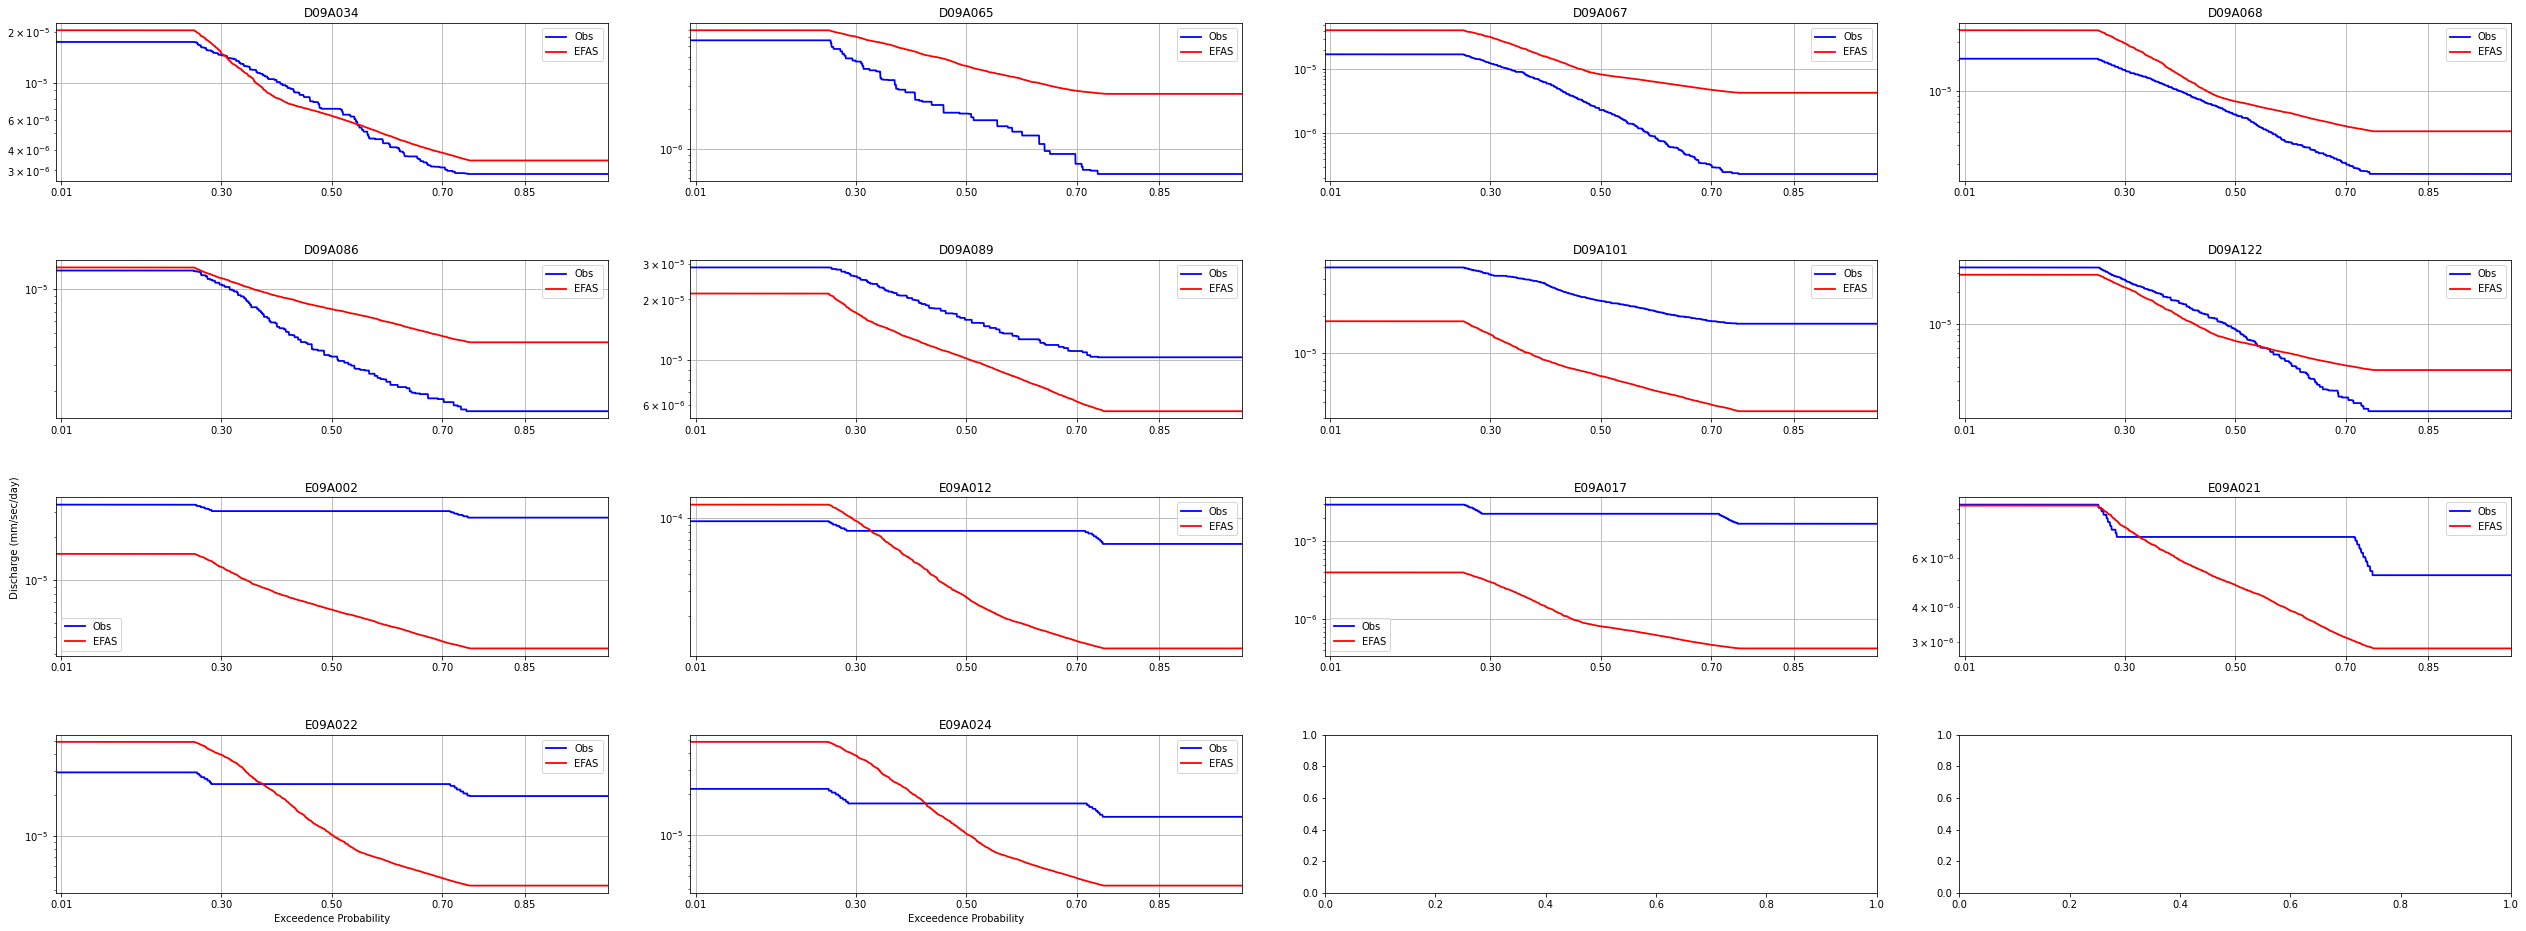

In [59]:
# Plot FDCs
fig, axs = plot.subplots(4,4, figsize=(44, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.15)
axs = axs.ravel()
for i in range(16):
    axs[i].plot(ObsSelSort.columns[i], data=ObsSelSortNorm,  linestyle='-', color='blue', linewidth=1.8, label='Obs')
    axs[i].plot(ObsSelSort.columns[i], data=EfasSelSortNorm,  linestyle='-', color='red', linewidth=1.8, label='EFAS')
    axs[i].set_yscale('log')
    axs[i].set_title(str(ObsSelSort.columns[i]))
    axs[i].set_xticks([0.01, 0.3, 0.5, 0.7, 0.85])
    axs[i].grid()
    axs[i].set_xlim(left=0, right=1)
    axs[i].legend()
    if i == 8:
        axs[i].set_ylabel('                         Discharge (mm/sec/day)', fontsize=10)
    if i > 11:
        axs[i].set_xlabel('Exceedence Probability', fontsize=10)

fig.savefig('FDC_Obs_Sim_Antalya.corrected.png')
fig.show()


In [60]:
# Define FDC thresholds
H5 = round(0.01 * len(ObsSelSortNorm)) + 1
H30 = round(0.30 * len(ObsSelSortNorm)) + 1
H50 = round(0.50 * len(ObsSelSortNorm)) + 1
H70 = round(0.70 * len(ObsSelSortNorm)) + 1
H85 = round(0.85 * len(ObsSelSortNorm)) + 1

In [61]:
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSelSortNorm[pg], ObsSelSortNorm[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    leng = len(TSSel)
    TSSel['Ind'] = range(0, leng )
    TSSel.set_index('Ind', inplace=True)
    # For observed values
    TSSel["H5Obs"] = np.log10(TSSel['Obs'][H5])
    TSSel["H50Obs"] = np.log10(TSSel['Obs'][H50])
    TSSel["H85Obs"] = np.log10(TSSel['Obs'][H85])
    TSSel["HSLObs"] = np.log10(TSSel['Obs'][H30]) - np.log10(TSSel['Obs'][H70])
    # For sim values
    TSSel["H5Sim"] = np.log10(TSSel['Sim'][H5])
    TSSel["H50Sim"] = np.log10(TSSel['Sim'][H50])
    TSSel["H85Sim"] = np.log10(TSSel['Sim'][H85])
    TSSel["HSLSim"] = np.log10(TSSel['Sim'][H30]) - np.log10(TSSel['Sim'][H70])

    StatsCalc = TSSel.iloc[0]
    StatsCalc["Station"] = pg

    Stats = Stats.append(StatsCalc)

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp/ipykernel_7252/180370898.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



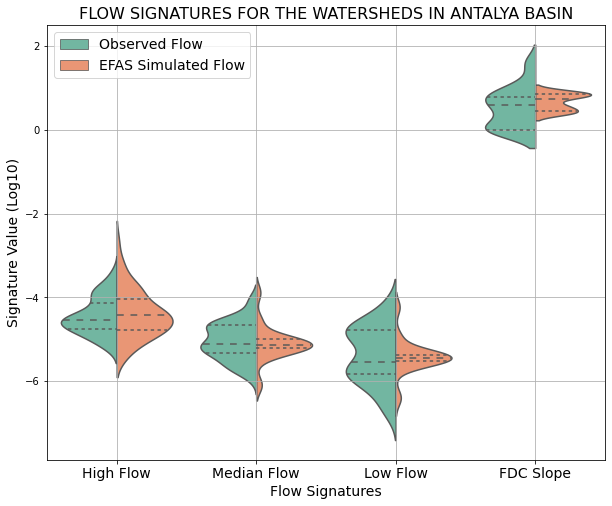

In [62]:
# Export Stats
Stats.to_excel('Stats_Antalya.xlsx')
StatsMeltedObs = Stats.melt(id_vars='Station', value_vars=["H5Obs", "H50Obs", "H85Obs", "HSLObs" ])
StatsMeltedSim = Stats.melt(id_vars='Station', value_vars=["H5Sim", "H50Sim", "H85Sim", "HSLSim" ])
StatsMeltedObs["Type"] = "Observed Flow"
StatsMeltedSim["Type"] = "EFAS Simulated Flow"
StatsMeltedObs['variable'] = StatsMeltedObs['variable'].map(lambda x: x.rstrip('Obs'))
StatsMeltedSim['variable'] = StatsMeltedSim['variable'].map(lambda x: x.rstrip('Sim'))

StatsMelted = pd.concat([StatsMeltedObs, StatsMeltedSim], ignore_index=True)
fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", hue="Type", data=StatsMelted, palette="Set2", split=True,
                    scale="count", inner="quartile")
axv.grid()
axv.legend(loc=2,prop={'size':14})
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['High Flow','Median Flow','Low Flow','FDC Slope']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('FLOW SIGNATURES FOR THE WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Signature Value (Log10)', fontsize=14)
axv.set_xlabel('Flow Signatures', fontsize=14)
fig.show()
fig.savefig('FDC_Signatures_Antalya.corrected.png')

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_7252/129016196.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



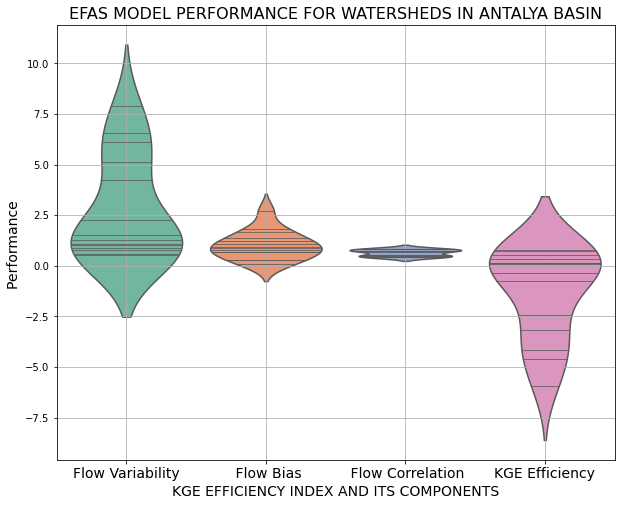

In [64]:
##KGE and Components
KGE = pd.DataFrame()
KGECalc = pd.DataFrame()
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSel[pg], ObsSel[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    # Calculate KGE Components
    TSSel["MeanObs"] = TSSel["Obs"].mean()
    TSSel["MeanSim"] = TSSel["Sim"].mean()

    TSSel["StdObs"] = TSSel["Obs"].std() / TSSel["MeanObs"]
    TSSel["StdSim"] = TSSel["Sim"].std() / TSSel["MeanSim"]

    TSSel["Alpha"] = TSSel["StdSim"] / TSSel["StdObs"]
    TSSel["Beta"] = TSSel["MeanSim"] / TSSel["MeanObs"]

    TSSel["Corr"] = TSSel["Sim"].corr(TSSel["Obs"])
    TSSel["KGE"] = 1 - ((TSSel["Corr"] - 1)**2 + (TSSel["Alpha"] - 1)**2 + (TSSel["Beta"] - 1)**2)**0.5
    KGECalc = TSSel.iloc[0]
    KGECalc["Station"] = pg

    KGE = KGE.append(KGECalc)

# Export KGE
KGE.to_excel('Stats_KGE_Antalya.xlsx')

# Plot KGE and Components
KGEMelted = KGE.melt(id_vars='Station', value_vars=["Alpha", "Beta", "Corr", "KGE"])

fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", data=KGEMelted, palette="Set2", split=True,
                    scale="count", inner="stick")
axv.grid()
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['Flow Variability',' Flow Bias',' Flow Correlation','KGE Efficiency']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('EFAS MODEL PERFORMANCE FOR WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Performance ', fontsize=14)
axv.set_xlabel('KGE EFFICIENCY INDEX AND ITS COMPONENTS', fontsize=14)
fig.show()
fig.savefig('KGE_Components_Antalya.Median.Drop.png')